In [ ]:
!pip install pyspark

In [ ]:
#Installing the necessary libraries
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes


In [ ]:
#Initializing the environment
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

In [ ]:
from graphframes import *
from pyspark import *
from pyspark.sql import *

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
spark = SparkSession.builder.appName("Churn Prediction").config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark3.0-s_2.12").getOrCreate()

In [ ]:
churn_status_df = spark.read.csv("/content/Telco_customer_churn_status.csv", header=True, inferSchema=True)
churn_df = spark.read.csv("/content/Telco_customer_churn.csv", header=True, inferSchema=True)

In [ ]:
# Rename overlapping columns in `churn_status_df` to prevent duplicates
columns_to_rename = {
    "Customer ID": "CustomerID_Status",
    "Count": "Count_Status",
    "Churn Label": "ChurnLabel_Status",
    "Churn Value": "ChurnValue_Status",
    "Churn Score": "ChurnScore_Status",
    "CLTV": "CLTV_Status",
    "Churn Reason": "ChurnReason_Status"
}

for original_col, new_col in columns_to_rename.items():
    churn_status_df = churn_status_df.withColumnRenamed(original_col, new_col)

# Now perform the join on the CustomerID
# Since `CustomerID` in churn_df and `CustomerID_Status` in churn_status_df represent the same data, we use these for the join condition
combined_df = churn_df.join(churn_status_df, churn_df.CustomerID == churn_status_df.CustomerID_Status, "inner")

# Optionally, drop the `CustomerID_Status` column if it's no longer needed, along with any other renamed duplicates you don't need
columns_to_drop = ['Count_Status', 'ChurnLabel_Status', 'ChurnValue_Status', 'ChurnScore_Status', 'CLTV_Status', 'ChurnReason_Status','CustomerID_Status']
final_df = combined_df.drop(*columns_to_drop)
# combined_df = combined_df.drop(*columns_to_drop)

# Show the result to verify the structure
final_df.show()


+----------+-----+-------------+----------+---------------+--------+--------------------+---------+-----------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-----------------+--------------------+---------------+-------------+-----------+-----------+-----------+----+--------------------+----------+-------+------------------+---------------+--------------+
|CustomerID|Count|      Country|     State|           City|Zip Code|            Lat Long| Latitude|  Longitude|Gender|Senior Citizen|Partner|Dependents|Tenure Months|Phone Service|  Multiple Lines|Internet Service|    Online Security|      Online Backup|  Device Protection|       Tech Support|       Streaming TV|   Streaming Movies|      Contract|Paperless Billing|      Payment Method|Monthly Charges|Total Charges|Churn Label|Churn Value|Churn Sc

In [ ]:
#Displaying the first 2 rows of the dataset
final_df.show(2, truncate=False)

+----------+-----+-------------+----------+-----------+--------+----------------------+---------+-----------+------+--------------+-------+----------+-------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------------+-----------------+----------------+---------------+-------------+-----------+-----------+-----------+----+----------------------------+----------+-------+------------------+---------------+--------------+
|CustomerID|Count|Country      |State     |City       |Zip Code|Lat Long              |Latitude |Longitude  |Gender|Senior Citizen|Partner|Dependents|Tenure Months|Phone Service|Multiple Lines|Internet Service|Online Security|Online Backup|Device Protection|Tech Support|Streaming TV|Streaming Movies|Contract      |Paperless Billing|Payment Method  |Monthly Charges|Total Charges|Churn Label|Churn Value|Churn Score|CLTV|Churn Reason                |Status ID |Quarter|Satisfact

In [ ]:
# Count the number of rows
print("Total rows:", final_df.count())

Total rows: 7043


In [ ]:
# Counts the total number of rows in the dataset
print("Number of observations:", final_df.count())

# Information of columns
print("Information of columns:\n", final_df.columns)

# Description of columns
print("Description of columns:")
final_df.describe().show()

# First few records
print("First few records:")
final_df.show()

Number of observations: 7043
Information of columns:
 ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason', 'Status ID', 'Quarter', 'Satisfaction Score', 'Customer Status', 'Churn Category']
Description of columns:
+-------+----------+-----+-------------+----------+------+------------------+--------------------+-----------------+------------------+------+--------------+-------+----------+------------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------------+-

**Identify churn rates among different customer groups categorized based on their monthly charges and tenure**

In [ ]:
from pyspark.sql.functions import when, col, avg

# Calculate median values for "Monthly Charges" and "Tenure Months"
median_monthly_charges = final_df.stat.approxQuantile("Monthly Charges", [0.5], 0)[0]
median_tenure_months = final_df.stat.approxQuantile("Tenure Months", [0.5], 0)[0]

# Categorize customers into groups based on their "Monthly Charges" and "Tenure Months"
final_df = final_df.withColumn("CustomerGroup",
    when(
        (col("Monthly Charges") <= median_monthly_charges) & (col("Tenure Months") <= median_tenure_months), "Low Spend, Short Tenure"
    ).when(
        (col("Monthly Charges") <= median_monthly_charges) & (col("Tenure Months") > median_tenure_months), "Low Spend, Long Tenure"
    ).when(
        (col("Monthly Charges") > median_monthly_charges) & (col("Tenure Months") <= median_tenure_months), "High Spend, Short Tenure"
    ).otherwise("High Spend, Long Tenure")
)

final_df = final_df.withColumn("IsChurned", when(col("Churn Label") == "Yes", 1).otherwise(0))

# Calculate churn rate for each group
churn_rate_by_group = final_df.groupBy("CustomerGroup").agg(
    (avg("IsChurned") * 100).alias("ChurnRate")
).orderBy("CustomerGroup")

# Display the churn rate by customer group
churn_rate_by_group.show()


+--------------------+------------------+
|       CustomerGroup|         ChurnRate|
+--------------------+------------------+
|High Spend, Long ...|18.676470588235293|
|High Spend, Short...| 58.03389830508474|
|Low Spend, Long T...| 5.509065550906555|
|Low Spend, Short ...|26.408787010506206|
+--------------------+------------------+



**Inference:**

1. The "High Spend, Short Tenure" group has the highest churn rate, significantly more than any other group. This indicates that newer customers with higher monthly charges are more likely to leave the service.

**Recommendation:**

1. To address the high churn in the "High Spend, Short Tenure" segment, the company should consider strategies like offering introductory promotions, gradual pricing plans, or enhanced customer service support early in the customer lifecycle

**What is the impact of contract type on customer churn?**

In [ ]:
from pyspark.sql.functions import when, col, avg

# Calculate churn rate by contract type
churn_rate_by_contract = final_df.groupBy("Contract").agg(
    (avg(when(col("Churn Label") == "Yes", 1).otherwise(0)) * 100).alias("ChurnRate")
).orderBy("ChurnRate")

churn_rate_by_contract.show()

+--------------+------------------+
|      Contract|         ChurnRate|
+--------------+------------------+
|      Two year| 2.831858407079646|
|      One year|11.269517990495586|
|Month-to-month| 42.70967741935484|
+--------------+------------------+



**How does tenure relate to churn?**

In [ ]:
# Categorize tenure into groups
final_df = final_df.withColumn("TenureGroup",
    when(col("Tenure Months") <= 12, "0-12 Months")
    .when((col("Tenure Months") > 12) & (col("Tenure Months") <= 24), "13-24 Months")
    .when((col("Tenure Months") > 24) & (col("Tenure Months") <= 36), "25-36 Months")
    .when((col("Tenure Months") > 36) & (col("Tenure Months") <= 48), "37-48 Months")
    .when((col("Tenure Months") > 48) & (col("Tenure Months") <= 60), "49-60 Months")
    .otherwise("Over 60 Months"))

# Calculate churn rate by tenure group
churn_rate_by_tenure = final_df.groupBy("TenureGroup").agg(
    (avg("IsChurned") * 100).alias("ChurnRate")
).orderBy("TenureGroup")

churn_rate_by_tenure.show()



+--------------+------------------+
|   TenureGroup|         ChurnRate|
+--------------+------------------+
|   0-12 Months|47.438243366880144|
|  13-24 Months|        28.7109375|
|  25-36 Months|21.634615384615387|
|  37-48 Months|19.028871391076116|
|  49-60 Months|14.423076923076922|
|Over 60 Months| 6.609808102345416|
+--------------+------------------+



**Is there a relationship between monthly charges and churn?**

In [ ]:
# Categorize monthly charges into ranges
final_df = final_df.withColumn("MonthlyChargesRange",
    when(col("Monthly Charges") <= 30, "0-30")
    .when((col("Monthly Charges") > 30) & (col("Monthly Charges") <= 60), "31-60")
    .when((col("Monthly Charges") > 60) & (col("Monthly Charges") <= 90), "61-90")
    .otherwise("Over 90"))

# Calculate churn rate by monthly charges range
churn_rate_by_monthly_charges = final_df.groupBy("MonthlyChargesRange").agg(
    (avg("IsChurned") * 100).alias("ChurnRate")
).orderBy("MonthlyChargesRange")

churn_rate_by_monthly_charges.show()


+-------------------+------------------+
|MonthlyChargesRange|         ChurnRate|
+-------------------+------------------+
|               0-30| 9.800362976406534|
|              31-60| 25.92885375494071|
|              61-90|33.906119027661354|
|            Over 90|  32.7774583093732|
+-------------------+------------------+



**Inference:**  

1. The churn rate increases with higher monthly charges, with the highest churn rate observed in the "Over 90" charges range. This indicates a possible price sensitivity among customers, where higher costs may lead to increased churn.

**Recommendation:**  

1. The company should consider revising its pricing strategy for the highest-spending customer segments or offer more value for money to justify the higher costs.

**Do additional services (like Online Security, Tech Support) affect churn rates?**

In [ ]:

churn_rate_by_online_security = final_df.groupBy("Online Security").agg(
    (avg("IsChurned") * 100).alias("ChurnRate")
).orderBy("Online Security")

churn_rate_by_online_security.show()


+-------------------+------------------+
|    Online Security|         ChurnRate|
+-------------------+------------------+
|                 No| 41.76672384219554|
|No internet service| 7.404980340760157|
|                Yes|14.611193660227837|
+-------------------+------------------+



**What is the distribution of tenure among churned and retained customers?**

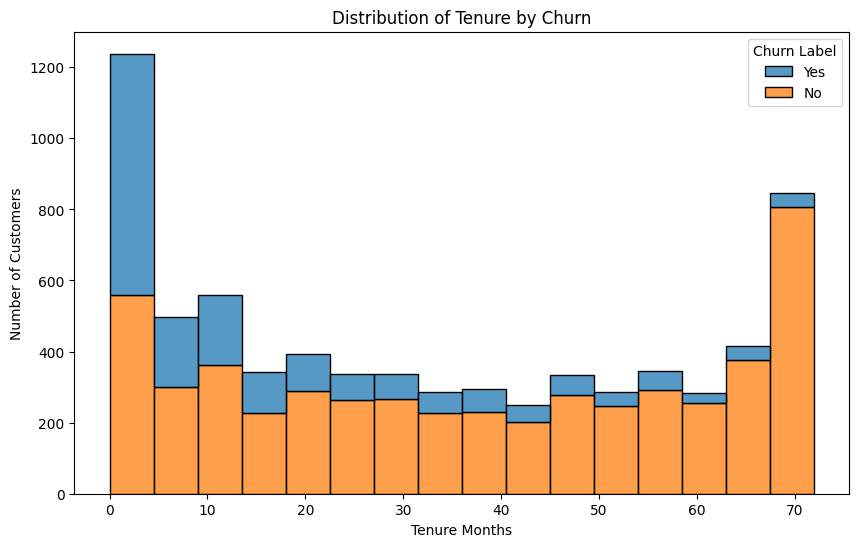

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

tenure_churn_pdf = final_df.select('Tenure Months', 'Churn Label').toPandas()


plt.figure(figsize=(10, 6))
sns.histplot(data=tenure_churn_pdf, x='Tenure Months', hue='Churn Label', multiple="stack")
plt.title('Distribution of Tenure by Churn')
plt.xlabel('Tenure Months')
plt.ylabel('Number of Customers')
plt.show()


**Inference:**

1. Churn is significantly higher among customers with a shorter tenure, particularly noticeable within the first 10 months, indicating that early engagement is critical to customer retention.

2. Customers with a tenure of around 70 months show a notable increase in retention, suggesting that if customers stay beyond a certain period, they are much less likely to churn.



**How do monthly charges affect churn?**

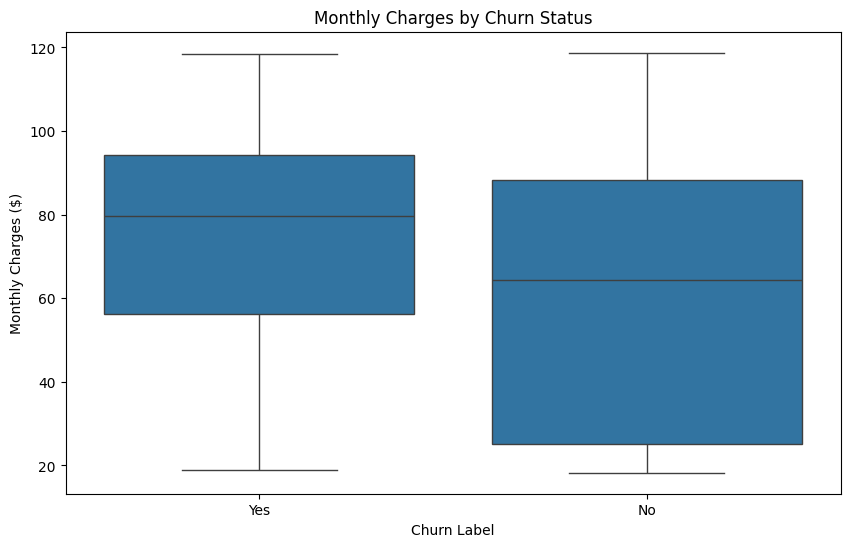

In [ ]:
monthly_charges_churn_pdf = final_df.select('Monthly Charges', 'Churn Label').toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=monthly_charges_churn_pdf, x='Churn Label', y='Monthly Charges')
plt.title('Monthly Charges by Churn Status')
plt.xlabel('Churn Label')
plt.ylabel('Monthly Charges ($)')
plt.show()


**What is the churn rate by contract type?**

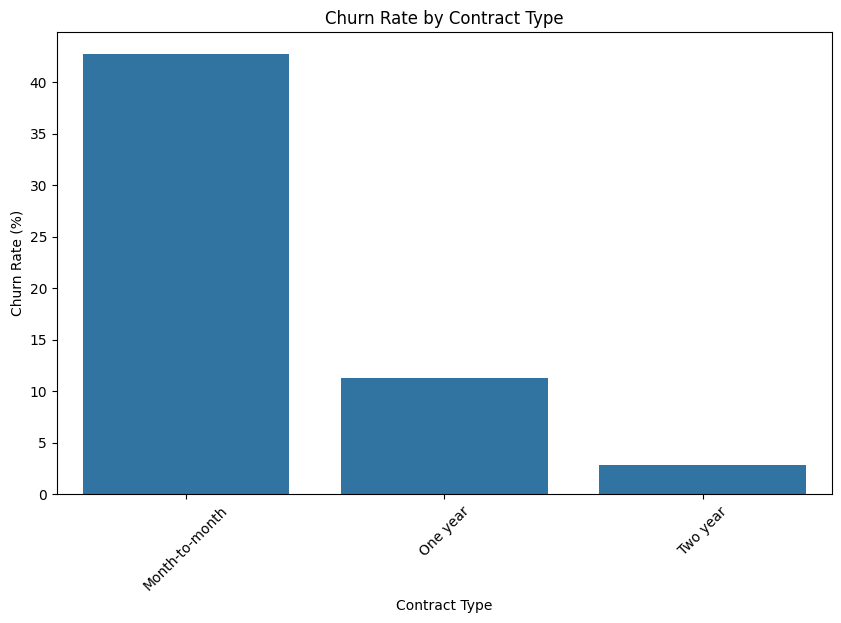

In [ ]:
churn_rate_by_contract_pdf = final_df.groupBy("Contract").agg(
    (avg(when(col("Churn Label") == "Yes", 1).otherwise(0)) * 100).alias("ChurnRate")
).toPandas()


plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rate_by_contract_pdf, x='Contract', y='ChurnRate')
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.show()


Churn is significantly higher among customers with a shorter tenure, particularly noticeable within the first 10 months, indicating that early engagement is critical to customer retention.
Customers with a tenure of around 70 months show a notable increase in retention, suggesting that if customers stay beyond a certain period, they are much less likely to churn.



**What is the impact of online security on churn?**

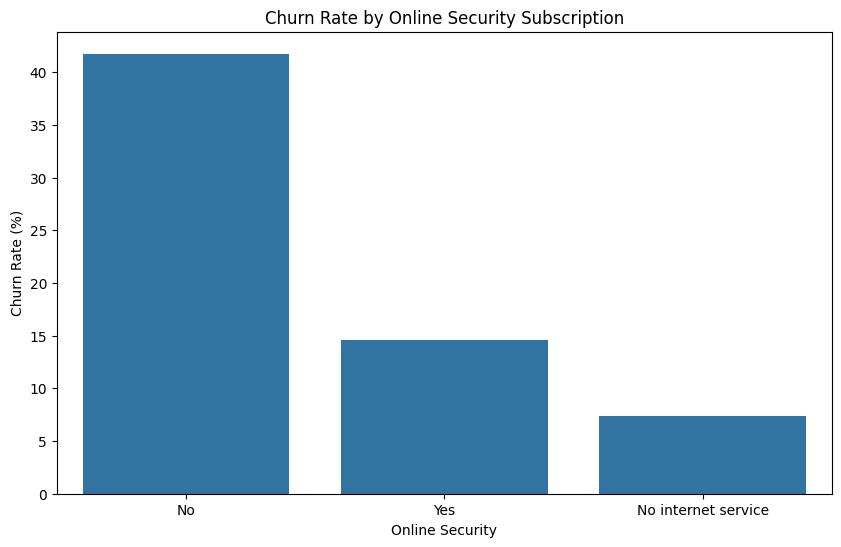

In [ ]:
churn_rate_by_online_security_pdf = final_df.groupBy("Online Security").agg(
    (avg(when(col("Churn Label") == "Yes", 1).otherwise(0)) * 100).alias("ChurnRate")
).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rate_by_online_security_pdf, x='Online Security', y='ChurnRate')
plt.title('Churn Rate by Online Security Subscription')
plt.xlabel('Online Security')
plt.ylabel('Churn Rate (%)')
plt.show()


In [ ]:
# Define the new columns 'InvitationSource' and 'ReferralCustomerID' with dummy values
invitation_sources = ['referred by', 'friend of', 'family member of', 'promotional offer', 'merchant collaboration']

# Add 'InvitationSource' column with random values
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from random import choice

# UDF to generate random invitation sources
def random_invitation_source():
    return choice(invitation_sources)

random_invitation_source_udf = udf(random_invitation_source, StringType())
final_df = final_df.withColumn("InvitationSource", random_invitation_source_udf())

# Add 'ReferralCustomerID' column with dummy values
customer_ids = final_df.select("CustomerID").distinct().collect()
customer_ids_list = [row["CustomerID"] for row in customer_ids]

# UDF to select random customerID
def random_customer_id():
    return choice(customer_ids_list)

random_customer_id_udf = udf(random_customer_id, StringType())
final_df = final_df.withColumn("ReferralCustomerID", random_customer_id_udf())

# Display the modified DataFrame
final_df.show(2, truncate=False)


+----------+-----+-------------+----------+-----------+--------+----------------------+---------+-----------+------+--------------+-------+----------+-------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------------+-----------------+----------------+---------------+-------------+-----------+-----------+-----------+----+----------------------------+----------+-------+------------------+---------------+--------------+------------------------+---------+-----------+-------------------+----------------+------------------+
|CustomerID|Count|Country      |State     |City       |Zip Code|Lat Long              |Latitude |Longitude  |Gender|Senior Citizen|Partner|Dependents|Tenure Months|Phone Service|Multiple Lines|Internet Service|Online Security|Online Backup|Device Protection|Tech Support|Streaming TV|Streaming Movies|Contract      |Paperless Billing|Payment Method  |Monthly Charges|Total Cha

In [ ]:
vertices_df = final_df.select('CustomerID', 'Gender', 'City','State').dropDuplicates().withColumnRenamed('CustomerID', 'id')

# Create Edges DataFrame
edges_df = final_df.select('CustomerID', 'ReferralCustomerID', 'InvitationSource').na.drop(subset=["ReferralCustomerID"]).withColumnRenamed('CustomerID', 'src').withColumnRenamed('ReferralCustomerID', 'dst').withColumnRenamed('InvitationSource', 'relation')

# Paths for saving the CSV files
vertices_file_path = '/content/drive/My Drive/Colab Notebooks/vertices'
edges_file_path = '/content/drive/My Drive/Colab Notebooks/edges'

# Save to CSV
vertices_df.write.csv(vertices_file_path, header=True, mode='overwrite')
edges_df.write.csv(edges_file_path, header=True, mode='overwrite')



In [ ]:
vertices = spark.read.option('header', 'true').csv('/content/drive/My Drive/Colab Notebooks/vertices/*.csv')
edges = spark.read.option('header', 'true').csv('/content/drive/My Drive/Colab Notebooks/edges/*.csv')

In [ ]:
mygraph = GraphFrame(vertices, edges)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


**Who are the top influencers in retaining customers?**

In [ ]:
edges.columns

['src', 'dst', 'relation']

In [ ]:
mygraph.degrees.orderBy(['degree'], ascending = [False]).show(5)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+----------+------+
|        id|degree|
+----------+------+
|9909-IDLEK|     8|
|8065-YKXKD|     8|
|1265-HVPZB|     7|
|0310-SUCIN|     7|
|3976-BWUCK|     7|
+----------+------+
only showing top 5 rows



In [ ]:
#Displaying top-5 users having max outDegrees

mygraph.outDegrees.orderBy(['outDegree'], ascending = [False]).show(5)

+----------+---------+
|        id|outDegree|
+----------+---------+
|4248-QPAVC|        1|
|0786-VSSUD|        1|
|3692-JHONH|        1|
|3528-HFRIQ|        1|
|6383-ZTSIW|        1|
+----------+---------+
only showing top 5 rows



**Observation**

1. A small number of individuals have a high degree of connectivity within the network, with the top individual linked to 9 others, suggesting a few key influential customers could be important in spreading word-of-mouth information about the service.


**What are the predominant sources of referral**

In [ ]:
invitation_source_counts = mygraph.edges.groupBy("relation").count().orderBy("count", ascending=False)
invitation_source_counts.show()

+--------------------+-----+
|            relation|count|
+--------------------+-----+
|         referred by| 1433|
|           friend of| 1426|
|   promotional offer| 1416|
|merchant collabor...| 1394|
|    family member of| 1374|
+--------------------+-----+



**Inference:**

1. The most common source of referrals is from "referred by," suggesting that existing customers' referral a significant role in attracting new customers.

**Recommedation:**  

The company should further incentivize referrals, which appear to be the leading source, also exploring ways to enhance the "referred by" method.

**How does the source of invitation influence the churn rate among customers**


In [ ]:
from pyspark.sql.functions import avg
edges_with_churn = mygraph.edges.join(final_df, mygraph.edges.dst == final_df.CustomerID)
churn_rate_by_source = edges_with_churn.groupBy("relation").agg(
    (avg("Churn Value") * 100).alias("ChurnRate")
).orderBy("ChurnRate", ascending=False)

churn_rate_by_source.show()

+--------------------+------------------+
|            relation|         ChurnRate|
+--------------------+------------------+
|merchant collabor...|28.766140602582496|
|         referred by|27.704117236566645|
|    family member of|27.219796215429405|
|   promotional offer|26.624293785310734|
|           friend of| 25.94670406732118|
+--------------------+------------------+



**Inference:**

1. The churn rate varies by invitation source, suggesting that how customers are referred to the service has an impact on their likelihood to churn.
2. "Merchant collaboration" is the referral source with the highest churn rate, while "friend of" has the lowest, indicating that customers referred through merchant collaborations might be less satisfied or have different expectations than those referred by friends.

**Recommendation:**

1. The company should conduct a thorough evaluation of their merchant collaboration programs to identify and address any factors contributing to higher churn rates.

In [ ]:
final_df.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zip Code: integer (nullable = true)
 |-- Lat Long: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Senior Citizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Tenure Months: integer (nullable = true)
 |-- Phone Service: string (nullable = true)
 |-- Multiple Lines: string (nullable = true)
 |-- Internet Service: string (nullable = true)
 |-- Online Security: string (nullable = true)
 |-- Online Backup: string (nullable = true)
 |-- Device Protection: string (nullable = true)
 |-- Tech Support: string (nullable = true)
 |-- Streaming TV: string (nullable = true)
 |-- Streaming Movies: string (nullable = true)
 |-- Contract:

Converting numeric columns to float type as they are in string type in the dataset

In [ ]:
from pyspark.sql.types import FloatType
final_df = final_df.withColumn("Total Charges", final_df["Total Charges"].cast(FloatType()))
final_df = final_df.withColumn("Tenure Months", final_df["Tenure Months"].cast(FloatType()))
final_df = final_df.withColumn("Monthly Charges", final_df["Monthly Charges"].cast(FloatType()))

Imputing values in Total Charges, Monthly Charges and Tenure Months with their corresponding mean values.

In [ ]:
#Missing Value Imputation
from pyspark.ml.feature import Imputer
#Imputation using Mean
imputer=Imputer(strategy='mean',inputCol=("Total Charges"), outputCol=("Total Charges"))
final_df=imputer.fit(final_df).transform(final_df)
final_df.show()

#Imputation using Mean
imputer=Imputer(strategy='mean',inputCol=("Monthly Charges"), outputCol=("Monthly Charges"))
final_df=imputer.fit(final_df).transform(final_df)
final_df.show()

#Imputation using Mean
imputer=Imputer(strategy='mean',inputCol=("Tenure Months"), outputCol=("Tenure Months"))
final_df=imputer.fit(final_df).transform(final_df)
final_df.show()

+----------+-----+-------------+----------+---------------+--------+--------------------+---------+-----------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-----------------+--------------------+---------------+-------------+-----------+-----------+-----------+----+--------------------+----------+-------+------------------+---------------+--------------+--------------------+---------+------------+-------------------+--------------------+------------------+
|CustomerID|Count|      Country|     State|           City|Zip Code|            Lat Long| Latitude|  Longitude|Gender|Senior Citizen|Partner|Dependents|Tenure Months|Phone Service|  Multiple Lines|Internet Service|    Online Security|      Online Backup|  Device Protection|       Tech Support|       Streaming TV|   Streaming Movies|      Contra

Replacing redundant values in 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies' columns for consistency across features.

In [ ]:
from pyspark.sql.functions import col, sum, when
columns_to_check = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']  # Replace with your actual column names

# Replace 'No internet service' with 'No' in the specified columns
for column in columns_to_check:
    final_df = final_df.withColumn(column, when(col(column) == 'No internet service', 'No').otherwise(col(column)))

# Show the result
final_df.show()

+----------+-----+-------------+----------+---------------+--------+--------------------+---------+-----------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------------+-----------------+--------------------+---------------+-------------+-----------+-----------+-----------+----+--------------------+----------+-------+------------------+---------------+--------------+--------------------+---------+------------+-------------------+--------------------+------------------+
|CustomerID|Count|      Country|     State|           City|Zip Code|            Lat Long| Latitude|  Longitude|Gender|Senior Citizen|Partner|Dependents|Tenure Months|Phone Service|  Multiple Lines|Internet Service|Online Security|Online Backup|Device Protection|Tech Support|Streaming TV|Streaming Movies|      Contract|Paperless Billing|      Payment Method|Monthly Charges|

Applying standard scaling to selected numeric features for model training

In [ ]:
#Standard Scaling with Pipeline
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
assembler = VectorAssembler(inputCols=["Tenure Months","Monthly Charges","Total Charges","Satisfaction Score"], outputCol="tMTS")
ss = StandardScaler(inputCol="tMTS", outputCol="tMTS_std_scaled")
pipeline = Pipeline(stages=[assembler, ss])
final_df=pipeline.fit(final_df).transform(final_df)
final_df.select('tMTS', 'tMTS_std_scaled').show(truncate=False)

+-----------------------------------------------+---------------------------------------------------------------------------------+
|tMTS                                           |tMTS_std_scaled                                                                  |
+-----------------------------------------------+---------------------------------------------------------------------------------+
|[2.0,53.849998474121094,108.1500015258789,1.0] |[0.08143494555602797,1.7896282530945118,0.04774833958400724,0.832184140751779]   |
|[2.0,70.69999694824219,151.64999389648438,2.0] |[0.08143494555602797,2.3496140318940846,0.06695363203253653,1.664368281503558]   |
|[8.0,99.6500015258789,820.5,3.0]               |[0.3257397822241119,3.311726336210166,0.36225161420181085,2.4965524222553372]    |
|[28.0,104.80000305175781,3046.050048828125,3.0]|[1.1400892377843916,3.4828793259102864,1.3448343048476454,2.4965524222553372]    |
|[49.0,103.69999694824219,5036.2998046875,1.0]  |[1.9951561661226853,3.44632

Applying one hot encoding to categorical columns and creating a vector to pass to the predictive model

In [ ]:
#String indexing for categorical columns
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["Gender", "Partner", "Dependents", "Phone Service", "Multiple Lines", "Internet Service", "Online Security", "Online Backup", "Device Protection", "Tech Support", "Streaming TV", "Streaming Movies", "Contract", "Paperless Billing", "Payment Method", "IsChurned"],outputCols=["newGender", "newPartner", "newDependents", "newPhoneService", "newMultipleLines", "newInternetService", "newOnlineSecurity", "newOnlineBackup", "newDeviceProtection", "newTechSupport", "newStreamingTV", "newStreamingMovies", "newContract", "newPaperlessBilling", "newPaymentMethod", "newIsChurned"])
#One hot encoding
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["newGender", "newPartner", "newDependents", "newPhoneService", "newMultipleLines", "newInternetService", "newOnlineSecurity", "newOnlineBackup", "newDeviceProtection", "newTechSupport", "newStreamingTV", "newStreamingMovies", "newContract", "newPaperlessBilling", "newPaymentMethod"],outputCols=["newGender2", "newPartner2", "newDependents2", "newPhoneService2", "newMultipleLines2", "newInternetService2", "newOnlineSecurity2", "newOnlineBackup2", "newDeviceProtection2", "newTechSupport2", "newStreamingTV2", "newStreamingMovies2", "newContract2", "newPaperlessBilling2", "newPaymentMethod2"])
#Vector Assembler
from pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["newGender2", "newPartner2", "newDependents2", "newPhoneService2", "newMultipleLines2", "newInternetService2", "newOnlineSecurity2", "newOnlineBackup2", "newDeviceProtection2", "newTechSupport2", "newStreamingTV2", "newStreamingMovies2", "newContract2", "newPaperlessBilling2", "newPaymentMethod2", "tMTS_std_scaled"],outputCol="all_features")

Training a logistic regression model on the created feature vector

In [ ]:
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(featuresCol='all_features', labelCol="newIsChurned")
from pyspark.ml import Pipeline
lrpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,log_reg])
training, test=final_df.randomSplit([0.75,0.25], seed=1000)
lrmodel=lrpipeline.fit(training)
lrresults=lrmodel.transform(test)
lrresults.show(2, truncate=False)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
lreval=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="newIsChurned")
lreval.evaluate(lrresults)

+----------+-----+-------------+----------+--------+--------+----------------------+---------+-----------+------+--------------+-------+----------+-------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------------+-----------------+-----------------------+---------------+-------------+-----------+-----------+-----------+----+-----------------------+----------+-------+------------------+---------------+---------------+------------------------+---------+--------------+-------------------+----------------+------------------+---------------------------------------+--------------------------------------------------------+------------------------------------------------+--------------------------------------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------------------+---------+------

0.9338383838383838

Calculating accuracy of the logistic regression model

In [ ]:
#Verifying the Results
lrresults=lrresults.withColumn("compare",lrresults['newIsChurned']-lrresults['prediction'])
correct=lrresults.filter(lrresults['compare']==0).count()
incorrect=lrresults.filter(lrresults['compare']!=0).count()
print("Accuracy of logistic regression model: ",correct/(correct+incorrect))

Accuracy of logistic regression model:  0.955593029792018


Training a decision tree model on the created feature vector

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
tree_model=DecisionTreeClassifier(featuresCol='all_features', labelCol="newIsChurned")
treepipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,tree_model])
training, test=final_df.randomSplit([0.75,0.25], seed=1000)
treemodel=treepipeline.fit(training)
treeresults=treemodel.transform(test)
treeresults.show(2, truncate=False)
treeeval=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="newIsChurned")
treeeval.evaluate(treeresults)

+----------+-----+-------------+----------+--------+--------+----------------------+---------+-----------+------+--------------+-------+----------+-------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------------+-----------------+-----------------------+---------------+-------------+-----------+-----------+-----------+----+-----------------------+----------+-------+------------------+---------------+---------------+------------------------+---------+--------------+-------------------+----------------+------------------+---------------------------------------+--------------------------------------------------------+------------------------------------------------+--------------------------------------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------------------+---------+------

0.915839770251535

Calculating accuracy of the decision tree model

In [ ]:
#Verifying the Results
treeresults=treeresults.withColumn("compare",treeresults['newIsChurned']-treeresults['prediction'])
correct=treeresults.filter(treeresults['compare']==0).count()
incorrect=treeresults.filter(treeresults['compare']!=0).count()
print("Accuracy of decision tree model: ",correct/(correct+incorrect))

Accuracy of decision tree model:  0.9499718943226532


Training a Random Forest model on the created feature vector

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rand_forest=RandomForestClassifier(featuresCol='all_features', labelCol="newIsChurned")
rf_pipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,rand_forest])
training, test=final_df.randomSplit([0.75,0.25], seed=1000)
rf_model=rf_pipeline.fit(training)
rf_results=rf_model.transform(test)
rf_results.show(2, truncate=False)
rf_eval=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="newIsChurned")
rf_eval.evaluate(rf_results)

+----------+-----+-------------+----------+--------+--------+----------------------+---------+-----------+------+--------------+-------+----------+-------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------------+-----------------+-----------------------+---------------+-------------+-----------+-----------+-----------+----+-----------------------+----------+-------+------------------+---------------+---------------+------------------------+---------+--------------+-------------------+----------------+------------------+---------------------------------------+--------------------------------------------------------+------------------------------------------------+--------------------------------------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------------------+---------+------

0.9681273519508844

Calculating accuracy of the Random Forest model

In [ ]:
#Verifying the Results
rf_results=rf_results.withColumn("compare",rf_results['newIsChurned']-rf_results['prediction'])
correct=rf_results.filter(rf_results['compare']==0).count()
incorrect=rf_results.filter(rf_results['compare']!=0).count()
print("Accuracy of random forest model: ",correct/(correct+incorrect))

Accuracy of random forest model:  0.9421023046655425


**Inference:**

The model with highest accuracy is logistic regression model with 95.55%.

**We can further use this predictive model for below purposes:**
1. Early Identification of At-Risk Customers: Predictive models can help identify customers who are likely to churn in the near future. By identifying these customers early, businesses can take proactive measures to retain them, such as offering targeted promotions, discounts, or personalized communication.
2. Customer Segmentation: Predictive models can segment customers based on their likelihood of churn and other relevant characteristics. This segmentation allows businesses to tailor their marketing and retention efforts to different customer segments, increasing the effectiveness of their initiatives.
3. Resource Allocation: Predictive models enable businesses to allocate resources more efficiently by focusing efforts on customers who are most likely to churn. This helps optimize marketing budgets, customer service resources, and other resources aimed at retaining customers, resulting in cost savings and improved effectiveness.
4. Improved Customer Experience: By proactively addressing the needs of at-risk customers, businesses can enhance the overall customer experience and satisfaction. This can lead to increased loyalty, positive word-of-mouth referrals, and higher customer lifetime value.
